In [41]:
import ROOT as r
import uproot
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

In [52]:
fdir = 'fit_16double'
fdir = 'fit_17cvlonly'
# rd = r.TFile.Open('fit_18double/fitDiagnostics.root')
# rd = r.TFile.Open('fit_17cvbcvl/fitDiagnostics.root')
rd = r.TFile.Open(fdir+'/fitDiagnostics.root')

In [53]:
rd.Get('fit_s').floatParsFinal()

In [54]:
par_names = rd.Get('fit_s').floatParsFinal().contentsString().split(',')
par_names = [p for p in par_names if 'smear' in p or 'scale' in p  or 'eff' in p]
par_names
out = {}

for pn in par_names:
    out[pn] = {}
    out[pn]['val'] = round(rd.Get('fit_s').floatParsFinal().find(pn).getVal(), 3)
    out[pn]['unc'] = round(rd.Get('fit_s').floatParsFinal().find(pn).getError(), 3)
out

{'CMS_scale': {'unc': 1.265, 'val': -1.0},
 'CMS_smear': {'unc': 0.369, 'val': 1.0},
 'effSF': {'unc': 0.167, 'val': 0.627},
 'effSF_un': {'unc': 0.514, 'val': 0.997}}

In [55]:
scaleval = 1
scaledat = 1
(80.379 + scaleval * scaledat * out['CMS_scale']['val']) / 80.379 , scaleval * scaledat * out['CMS_scale']['unc'] / 80.379 
out['scale'] = {}
out['scale']['val'] = (80.379 + scaleval * scaledat * out['CMS_scale']['val']) / 80.379
out['scale']['unc'] = scaleval * scaledat * out['CMS_scale']['unc'] / 80.379  

In [56]:
smearval = 0.5
smeardat = 0.1
1/(1+smeardat*smearval*out['CMS_smear']['val']), smeardat*smearval/((1+out['CMS_smear']['unc']*smeardat*smearval)*(1+out['CMS_smear']['unc']*smeardat*smearval))
out['smear'] = {}
out['smear']['val'] = 1/(1+smeardat*smearval*out['CMS_smear']['val'])
out['smear']['unc'] = smeardat*smearval/((1+out['CMS_smear']['unc']*smeardat*smearval)*(1+out['CMS_smear']['unc']*smeardat*smearval))

In [57]:
# fd = uproot.open('fitdir/fitDiagnostics.root')
fd = uproot.open(fdir+'/fitDiagnostics.root')
#fd['shapes_fit_s/wsfpasspass'].keys()

In [58]:
def convTH1(TH1):
    vals = TH1.values
    edges = TH1.edges
    variances = TH1.variances
    vals = vals * np.diff(edges)
    variances = variances * np.diff(edges)
    return vals, edges, np.sqrt(variances)


def covnTGA(tgasym):
        # https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/wiki/nonstandard
        # Rescale density by binwidth for actual value
        _binwidth = tgasym._fEXlow + tgasym._fEXhigh
        _x = tgasym._fX
        _y = tgasym._fY * _binwidth
        _xerrlo, _xerrhi = tgasym._fEXlow, tgasym._fEXhigh
        _yerrlo, _yerrhi = tgasym._fEYlow * _binwidth, tgasym._fEYhigh * _binwidth
        return _x, _y, [_yerrlo, _yerrhi], [_xerrlo, _xerrhi]
    
# convTH1(fd['shapes_fit_s/wsfpass/qcd'])

In [59]:
plt.style.use([hep.style.ROOT, {'font.size': 16}])

In [60]:
fd['shapes_fit_s'].keys()

['wsfSingleFail;1', 'wsfSinglePass;1']

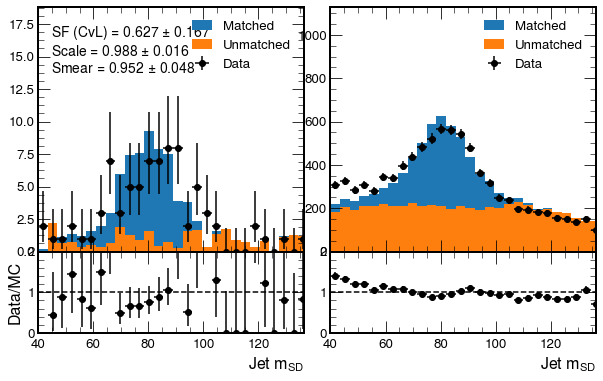

In [61]:
shapetype = 'shapes_fit_s'
#shapetype = 'shapes_prefit'
# ho1 = convTH1(fd[shapetype+'/wsfpasspass/qcd'])
# ho2 = convTH1(fd[shapetype+'/wsfpasspass/wqq'])
# tgo = covnTGA(fd[shapetype+'/wsfpasspass/data'])
# ho1 = convTH1(fd[shapetype+'/wsfpassfail/qcd'])
# ho2 = convTH1(fd[shapetype+'/wsfpassfail/wqq'])
# tgo = covnTGA(fd[shapetype+'/wsfpassfail/data'])
# ho1 = convTH1(fd[shapetype+'/wsffail/qcd'])
# ho2 = convTH1(fd[shapetype+'/wsffail/wqq'])
# tgo = covnTGA(fd[shapetype+'/wsffail/data'])


f, (ax1, ax2) = plt.subplots(2,2, figsize=(10, 6), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0.1)

for i, reg in enumerate(['wsfSinglePass', 'wsfSingleFail']):
    ho1 = convTH1(fd[shapetype+'/'+reg+'/qcd'])
    ho2 = convTH1(fd[shapetype+'/'+reg+'/wqq'])
    tgo = covnTGA(fd[shapetype+'/'+reg+'/data'])
    
    ax1[i].errorbar(tgo[0], tgo[1], yerr=tgo[2], xerr=tgo[3], fmt='o', color='black', label='Data')
    hep.histplot([ho1[0], ho2[0]], ho1[1], stack=True, ax=ax1[i], label=['Unmatched', "Matched"], histtype='fill')

    ax1[i].set_xlim(40, 136.5)
    ax1[i].legend()

    from uncertainties import unumpy
    data = unumpy.uarray(tgo[1], tgo[2])
    mc1 =  unumpy.uarray(ho1[0], ho1[2])
    mc2 =  unumpy.uarray(ho2[0], ho2[2])
    ratio = data/(mc1 + mc2)

    ax2[i].errorbar(tgo[0], unumpy.nominal_values(ratio)[0], unumpy.std_devs(ratio), xerr=tgo[3], fmt='o', color='black', label='Data')
    ax2[i].hlines(1, 40, 150, linestyle='--')
    ax2[i].set_ylim(0, 2)
    if i == 0:
        #hep.cms.cmslabel(ax=ax1[i],  rlabel="")
        ax2[i].set_ylabel("Data/MC")
    ax2[i].set_xlabel("Jet $m_{SD}$", x=1, ha='right');
#     ax1[0].set_title('Pass CvB+N2, Pass CvL')
#     ax1[1].set_title('Pass CvB+N2, Fail CvL')
#     ax1[2].set_title('Fail All')
    ax1[i].set_ylim(None, ax1[i].get_ylim()[-1]*1.5)
    
sfstr = (
         "SF (CvL) = {:.3f} $\pm$ {:.3f}".format(out['effSF']['val'], out['effSF']['unc'])
         + "\nScale = {:.3f} $\pm$ {:.3f}".format(out['scale']['val'], out['scale']['unc'])
         + "\nSmear = {:.3f} $\pm$ {:.3f}".format(out['smear']['val'], out['smear']['unc'])
        )
    
at = AnchoredText(sfstr,
              loc='upper left', frameon=False, prop=dict(size=14)
              )
ax1[0].add_artist(at);


KeyError: not found: 'wsfSecondaryPass'
 in file: fit_17cvlonly/fitDiagnostics.root

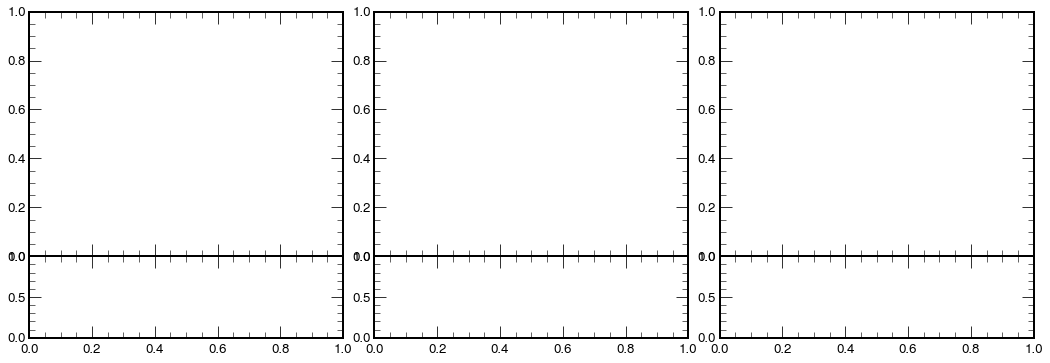

In [30]:
shapetype = 'shapes_fit_s'

f, (ax1, ax2) = plt.subplots(2,3, figsize=(18, 6), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0.1)

for i, reg in enumerate(['wsfSecondaryPass', 'wsfSecondaryFail', 'wsfPrimaryFail']):
    ho1 = convTH1(fd[shapetype+'/'+reg+'/qcd'])
    ho2 = convTH1(fd[shapetype+'/'+reg+'/wqq'])
    tgo = covnTGA(fd[shapetype+'/'+reg+'/data'])
    
    ax1[i].errorbar(tgo[0], tgo[1], yerr=tgo[2], xerr=tgo[3], fmt='o', color='black', label='Data')
    hep.histplot([ho1[0], ho2[0]], ho1[1], stack=True, ax=ax1[i], label=['Unmatched', "Matched"], histtype='fill')

    ax1[i].set_xlim(40, 136.5)
    ax1[i].legend()

    from uncertainties import unumpy
    data = unumpy.uarray(tgo[1], tgo[2])
    mc1 =  unumpy.uarray(ho1[0], ho1[2])
    mc2 =  unumpy.uarray(ho2[0], ho2[2])
    ratio = data/(mc1 + mc2)

    ax2[i].errorbar(tgo[0], unumpy.nominal_values(ratio)[0], unumpy.std_devs(ratio), xerr=tgo[3], fmt='o', color='black', label='Data')
    ax2[i].hlines(1, 40, 150, linestyle='--')
    ax2[i].set_ylim(0, 2)
    if i == 0:
        #hep.cms.cmslabel(ax=ax1[i],  rlabel="")
        ax2[i].set_ylabel("Data/MC")
    ax2[i].set_xlabel("Jet $m_{SD}$", x=1, ha='right');
    ax1[0].set_title('Pass CvB+N2, Pass CvL')
    ax1[1].set_title('Pass CvB+N2, Fail CvL')
    ax1[2].set_title('Fail All')
    ax1[i].set_ylim(None, ax1[i].get_ylim()[-1]*1.5)
    
sfstr = ("SF (CvL) = {:.3f} $\pm$ {:.3f}".format(out['effwSF']['val'], out['effwSF']['unc'])
         + "\nSF (CvB+N2) = {:.3f} $\pm$ {:.3f}".format(out['effSF']['val'], out['effSF']['unc'])
         + "\nScale = {:.3f} $\pm$ {:.3f}".format(out['scale']['val'], out['scale']['unc'])
         + "\nSmear = {:.3f} $\pm$ {:.3f}".format(out['smear']['val'], out['smear']['unc'])
        )
    
at = AnchoredText(sfstr,
              loc='upper left', frameon=False, prop=dict(size=14)
              )
ax1[0].add_artist(at);


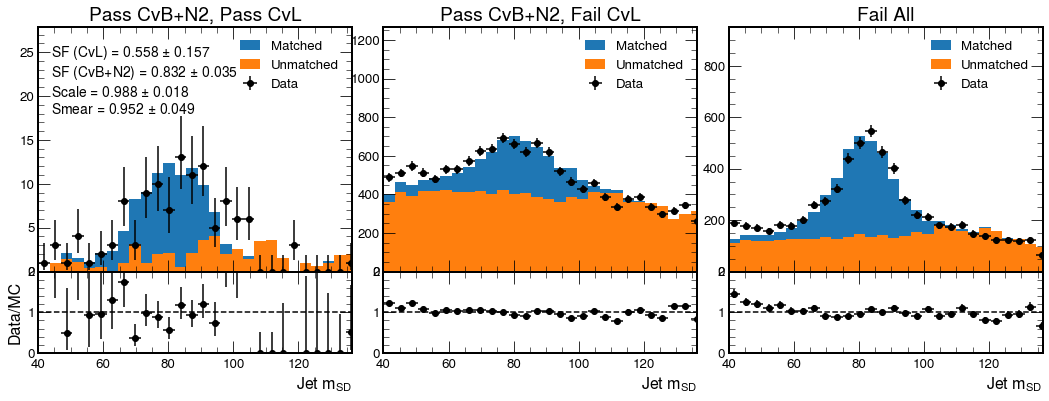

In [64]:
import numpy as np
from scipy.special import binom

In [69]:
# Construct Bernstein matrix for each dimension
_bmatrices = []
for idim, n in enumerate((1,2)):
    v = np.arange(n + 1)
    bmat = np.einsum("l,lv,lv->vl", binom.outer(n, v), binom.outer(v, v), np.power(-1., np.subtract.outer(v, v)))
    bmat[np.greater.outer(v, v)] = 0  # v > l
    _bmatrices.append(bmat)

In [70]:
_bmatrices[0]

array([[ 1., -1.],
       [ 0.,  1.]])

In [71]:
_bmatrices[1]

array([[ 1., -2.,  1.],
       [ 0.,  2., -2.],
       [ 0.,  0.,  1.]])